In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import json
import time
import os
from models import LatentVarNet3000
import tensorflow as tf

InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

# eICU

In [588]:
results_dict[0].keys()

dict_keys(['comm_round_stats', 'config', 'global_scores', 'local_performance', 'pooled_exp'])

In [185]:
with open('experiments/fed-pheno-LSTM_2019-06-26_14-43-26.json', 'r') as f:
    results_dict = json.load(f)

In [589]:
pooled_df = pd.Series(results_dict[0]['pooled_exp']['pooled_data_auc'])

In [603]:
results_dict[0]['pooled_exp'].keys()

dict_keys(['pooled_data_auc', 'pooled_data_auc_by_hsp', 'pooled_data_auc_by_hsp_fine_tuned'])

In [606]:
pooled_df_tune = pd.DataFrame(results_dict[0]['pooled_exp']['pooled_data_auc_by_hsp_fine_tuned'])

In [608]:
pooled_df_hsp = pd.DataFrame(results_dict[0]['pooled_exp']['pooled_data_auc_by_hsp'])

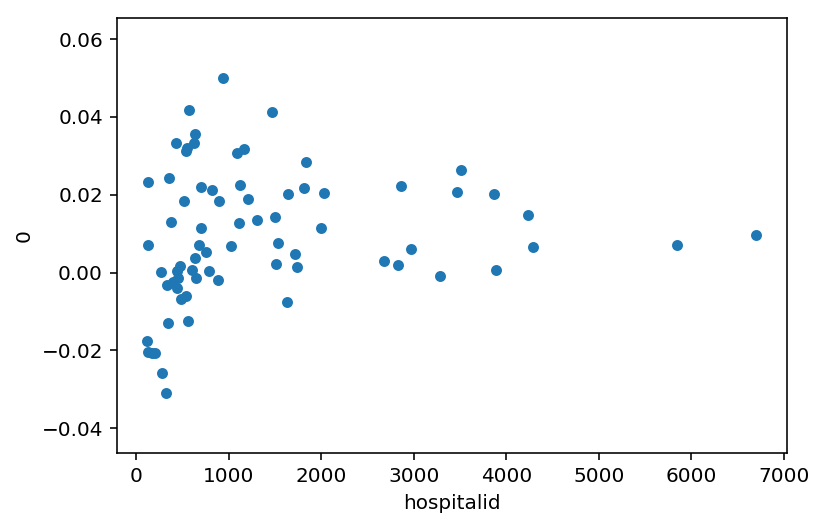

In [619]:
pd.concat([(pooled_df_tune - pooled_df_hsp).mean(axis=0).T, hsp_sizes], axis=1).plot.scatter(x='hospitalid', y=0)


In [620]:
(pooled_df_tune - pooled_df_hsp).mean(axis=0).mean()

0.009545768774454405

In [590]:
patient = pd.read_pickle('patient_hsp.pickle')

In [591]:
hsp_sizes = patient.hospitalid.value_counts()

In [592]:
hospital = pd.read_csv('hospital.csv')

In [593]:
phenotypes = pd.read_pickle('phenotypes.pickle')
phenotypes = pd.concat([patient['hospitalid'],phenotypes], 
          axis=1, join='inner').reset_index().set_index(['hospitalid', 'patientunitstayid']).sort_index()

In [595]:
scores_df = pd.DataFrame.from_dict(results_dict[0]['global_scores'])
local_perf = pd.DataFrame.from_dict(results_dict[0]['local_performance'], orient='index')
scores_df.index = scores_df.index.astype(int)
local_perf.index = local_perf.index.astype(int)
scores_df.columns = scores_df.columns.astype(int)
local_perf.columns = local_perf.columns.astype(int)

In [596]:
results_df = (scores_df.groupby(level=0).apply(
    lambda df: pd.DataFrame(
        np.apply_along_axis(
            np.stack, axis=1, arr=df.values)
        .squeeze()))
 .rename_axis(['hsp_id', 'comm_rounds']))

In [597]:
last_scores = results_df.groupby(level=0).apply(lambda df: df.reset_index(level=0,drop=True).loc[9])
auc_change_pheno = (last_scores - local_perf)

#### Pooling data resulted in 9 point increase in AUC relative to FedAvg (avg 70% vs 60%), and 14 point increase relative to local performance averages

In [598]:
(pooled_df - last_scores.mean()).mean()

0.08266876363021454

In [599]:
(pooled_df - local_perf.mean()).mean()

0.13816947895519946

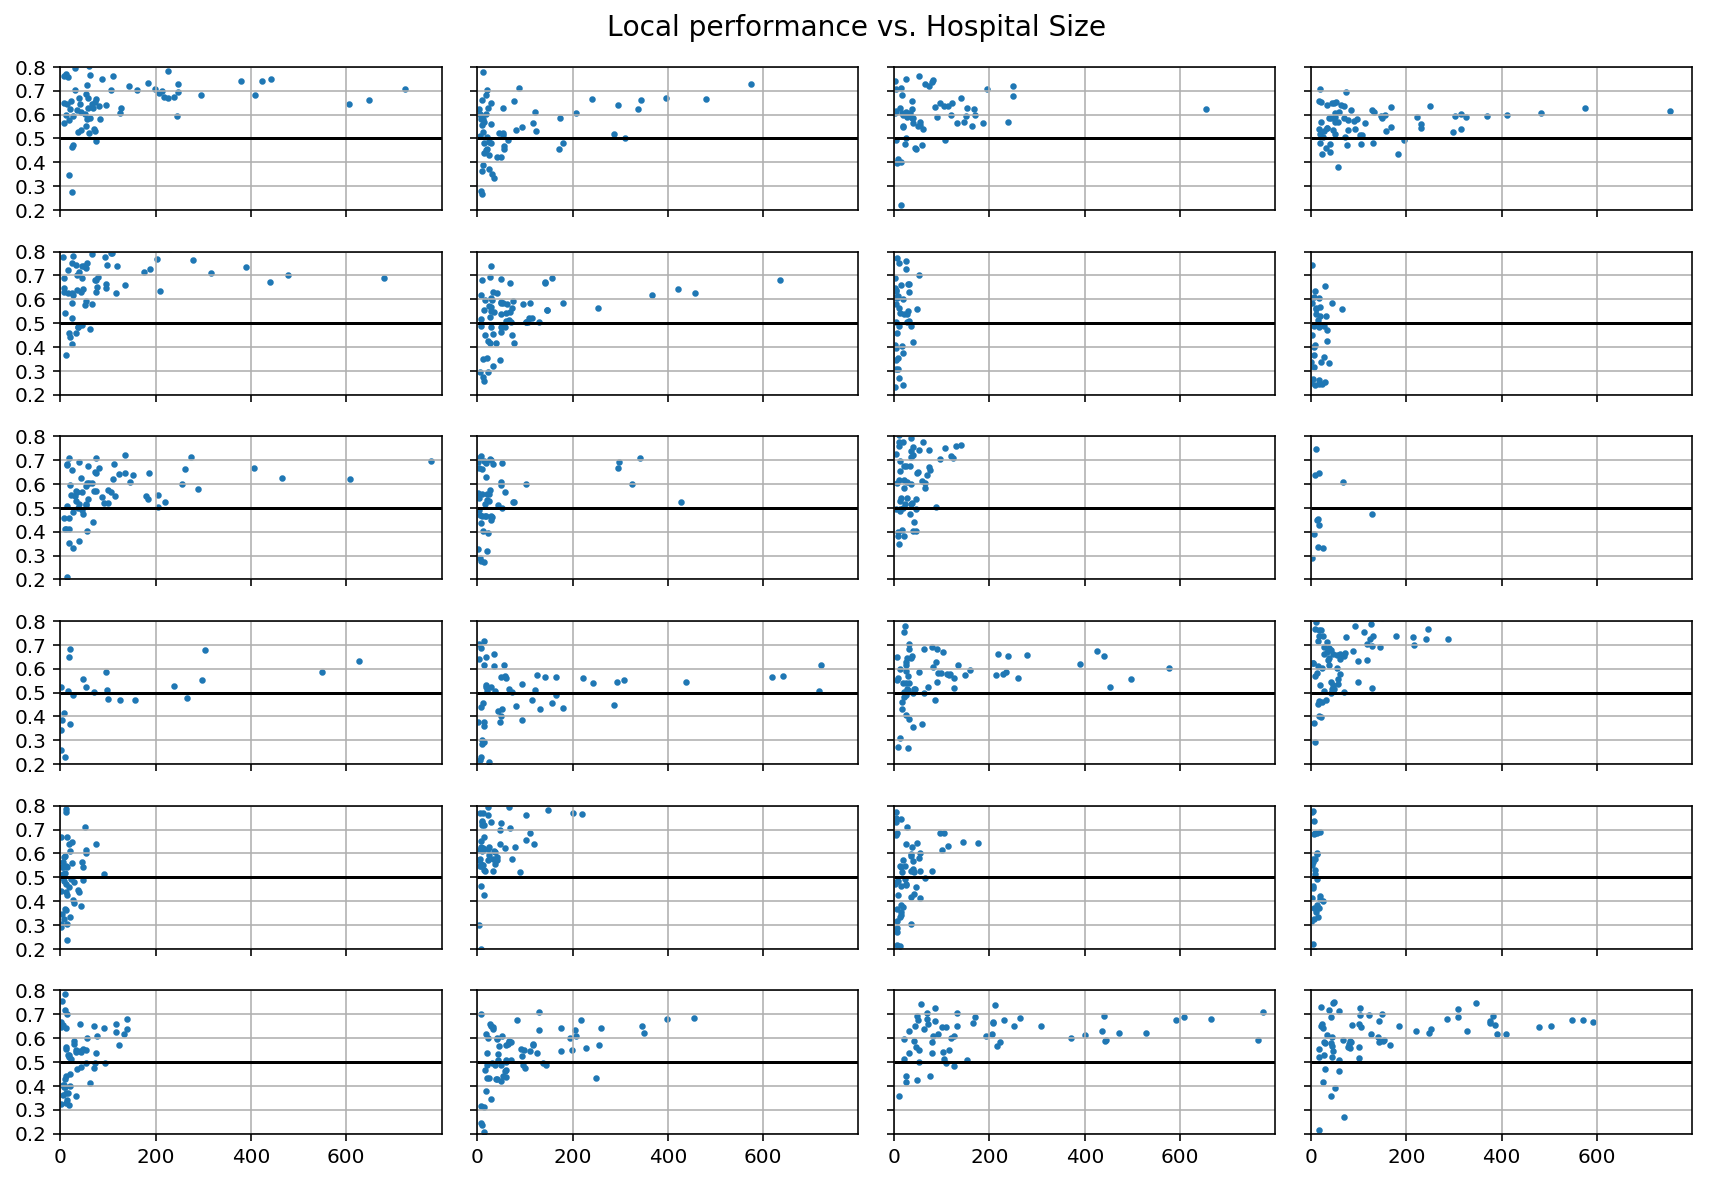

In [600]:
fig, axes = plt.subplots(6,4, figsize=(12,8), sharey=True, sharex=True)
plt.ylim(0.2, 0.8)
plt.xlim(0,800)
for i, ax in enumerate(axes.flatten()):
    ax.scatter(phenotypes.groupby(level=0).count().iloc[:,i], local_perf[i],s=5)
    ax.hlines(0.5,0, 800, )
    ax.grid(True)
    ax.set_yticks(np.arange(0.2, 0.9, 0.1))
    ax.set_xticks(np.arange(0, 800, 200))
    
st = fig.suptitle("Local performance vs. Hospital Size", fontsize=14)
st.set_y(1.02)
plt.tight_layout();
    

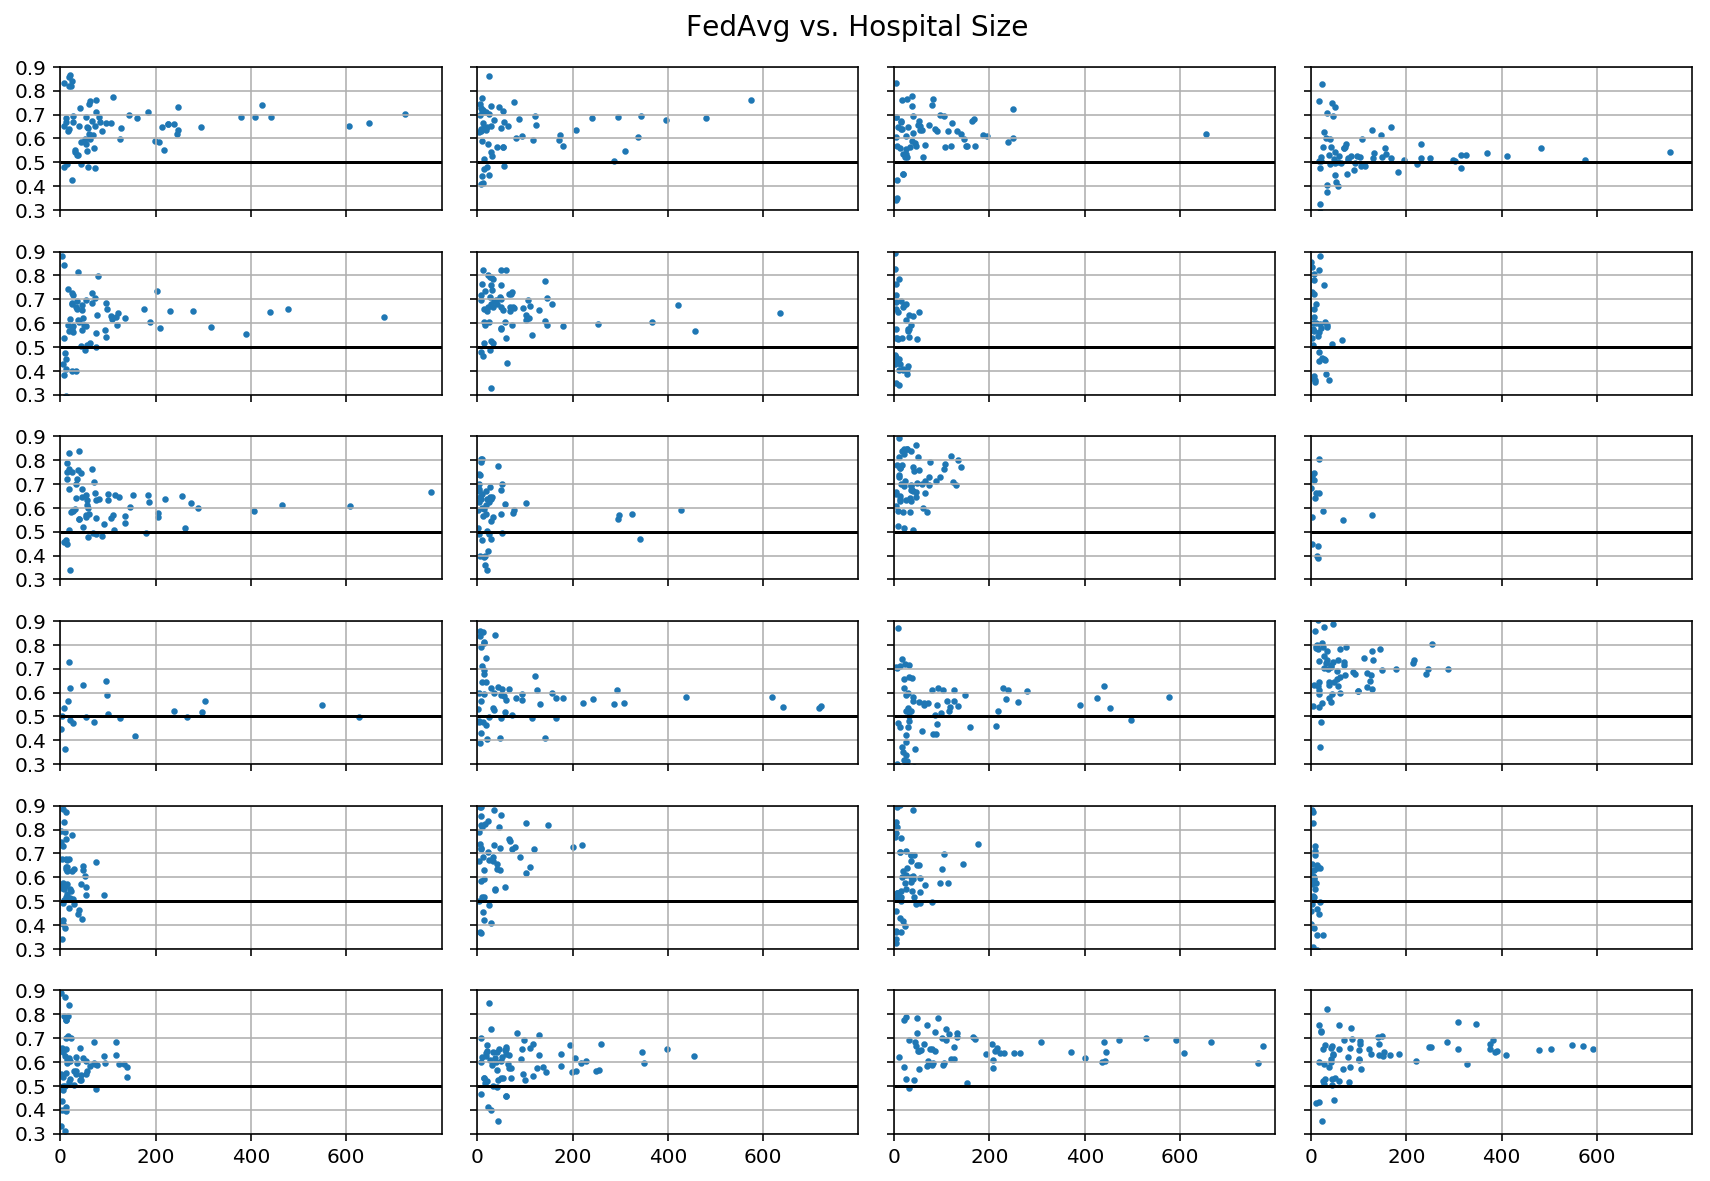

In [550]:
fig, axes = plt.subplots(6,4, figsize=(12,8), sharey=True, sharex=True)
plt.ylim(0.3,0.8)
plt.xlim(0,800)
for i, ax in enumerate(axes.flatten()):
    ax.scatter(phenotypes.groupby(level=0).count().iloc[:,i], last_scores[i] ,s=5)
    ax.hlines(0.5,0, 800, )
    ax.grid(True)
    ax.set_yticks(np.arange(0.3, 0.9, 0.1))
    ax.set_xticks(np.arange(0, 800, 200))
    
st = fig.suptitle("FedAvg vs. Hospital Size", fontsize=14)
st.set_y(1.02)
plt.tight_layout();
    

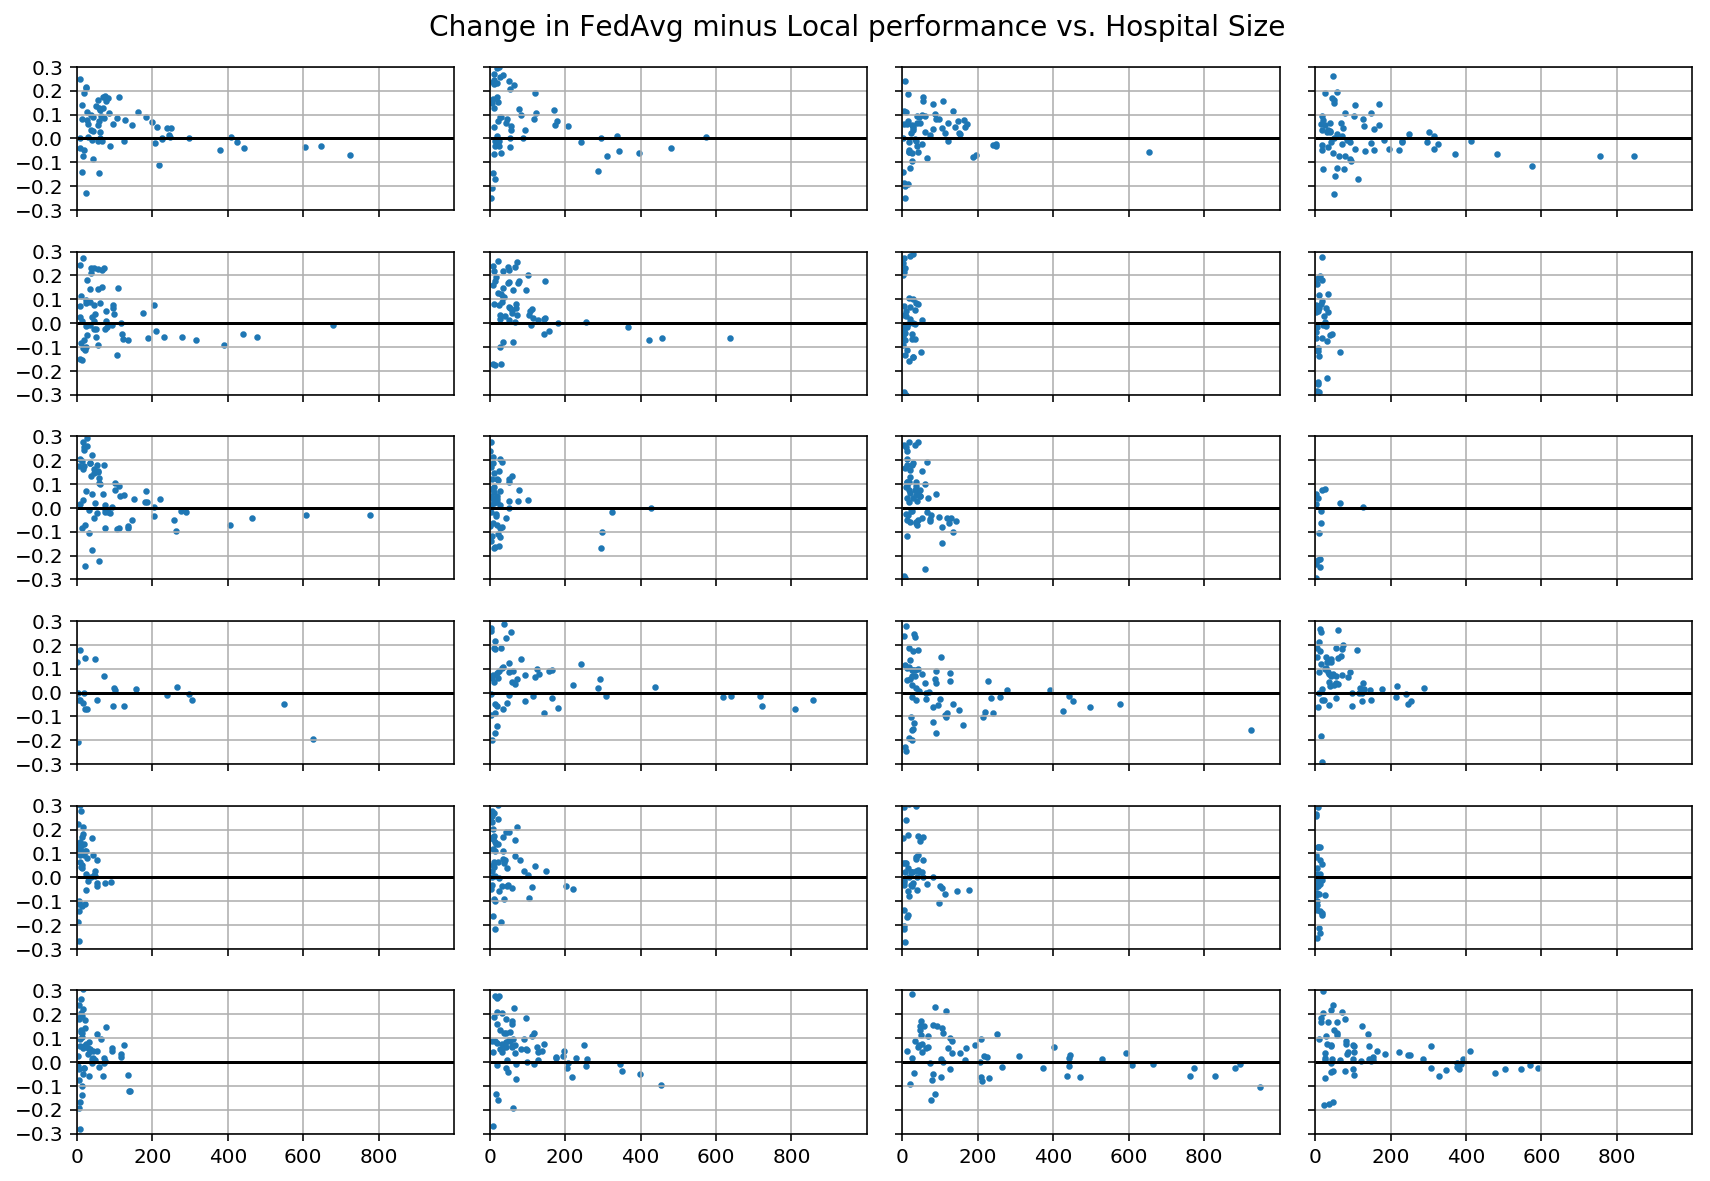

In [548]:
fig, axes = plt.subplots(6,4, figsize=(12,8), sharey=True, sharex=True)
plt.ylim(-0.3,0.3)
plt.xlim(0,1000)
for i, ax in enumerate(axes.flatten()):
    ax.scatter(phenotypes.groupby(level=0).count().iloc[:,i], last_scores[i] - local_perf[i],s=5)
    ax.hlines(0,0, 1000, )
    ax.grid(True)
    ax.set_yticks(np.arange(-0.3, 0.4, 0.1))
    ax.set_xticks(np.arange(0, 1000, 200))
    

st = fig.suptitle("Change in FedAvg minus Local performance vs. Hospital Size", fontsize=14)
st.set_y(1.02)
plt.tight_layout();
    

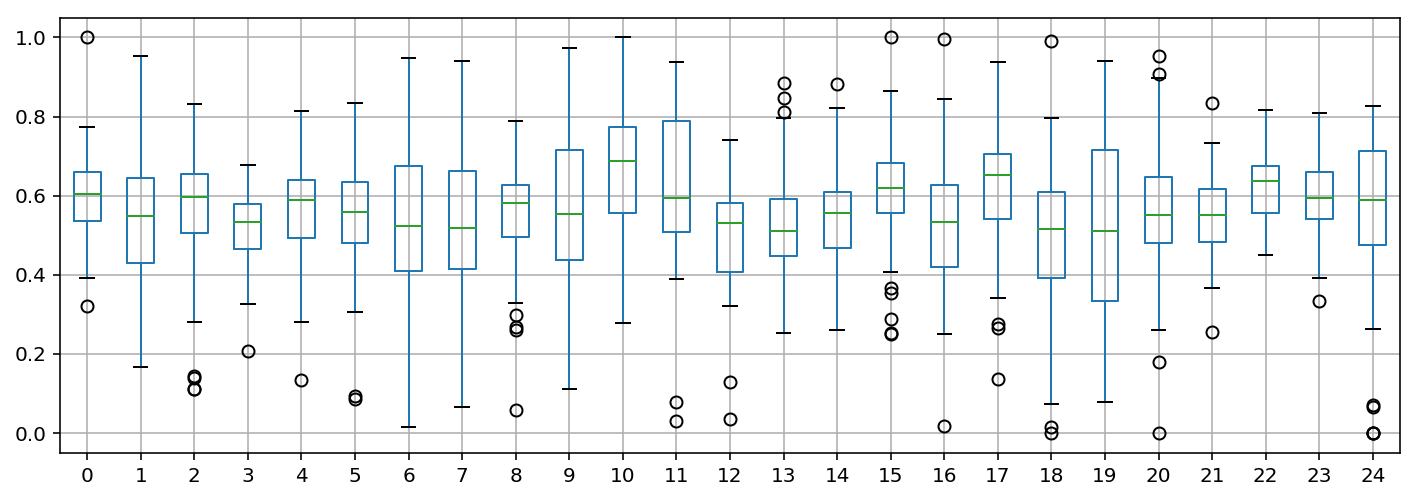

In [408]:
local_perf.boxplot(figsize=(12,4))

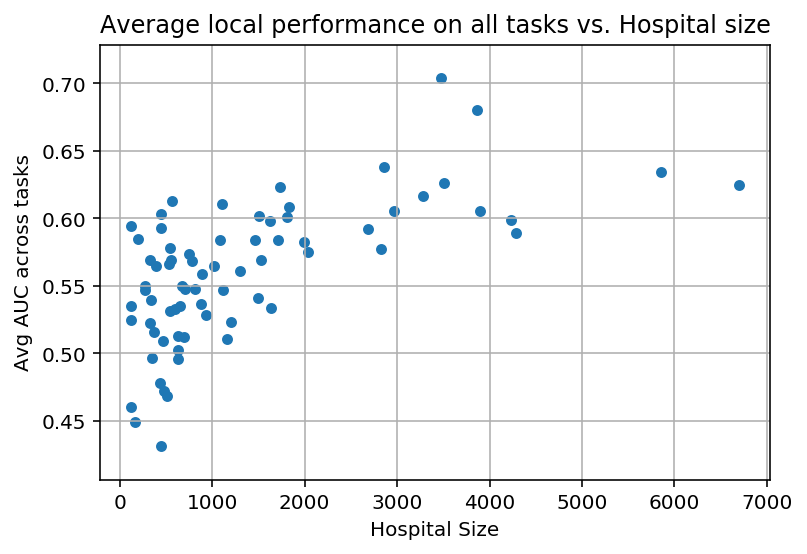

In [523]:
pd.concat([local_perf.mean(axis=1), hsp_sizes], axis=1).plot.scatter(x='hospitalid', y=0)
plt.title('Average local performance on all tasks vs. Hospital size')
plt.xlabel('Hospital Size')
plt.ylabel('Avg AUC across tasks')
plt.grid(True);

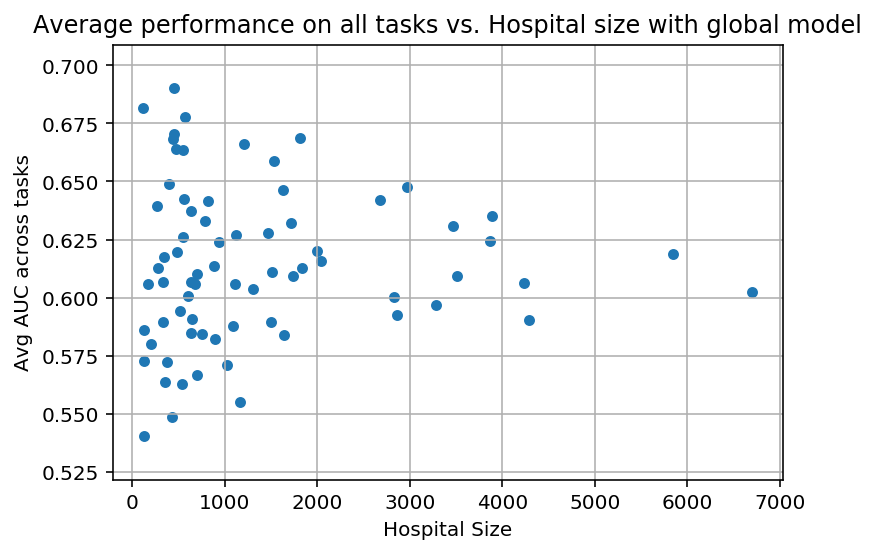

In [524]:
pd.concat([last_scores.mean(axis=1), hsp_sizes], axis=1).plot.scatter(x='hospitalid', y=0)
plt.title('Average performance on all tasks vs. Hospital size with global model')
plt.xlabel('Hospital Size')
plt.ylabel('Avg AUC across tasks')
plt.grid(True);

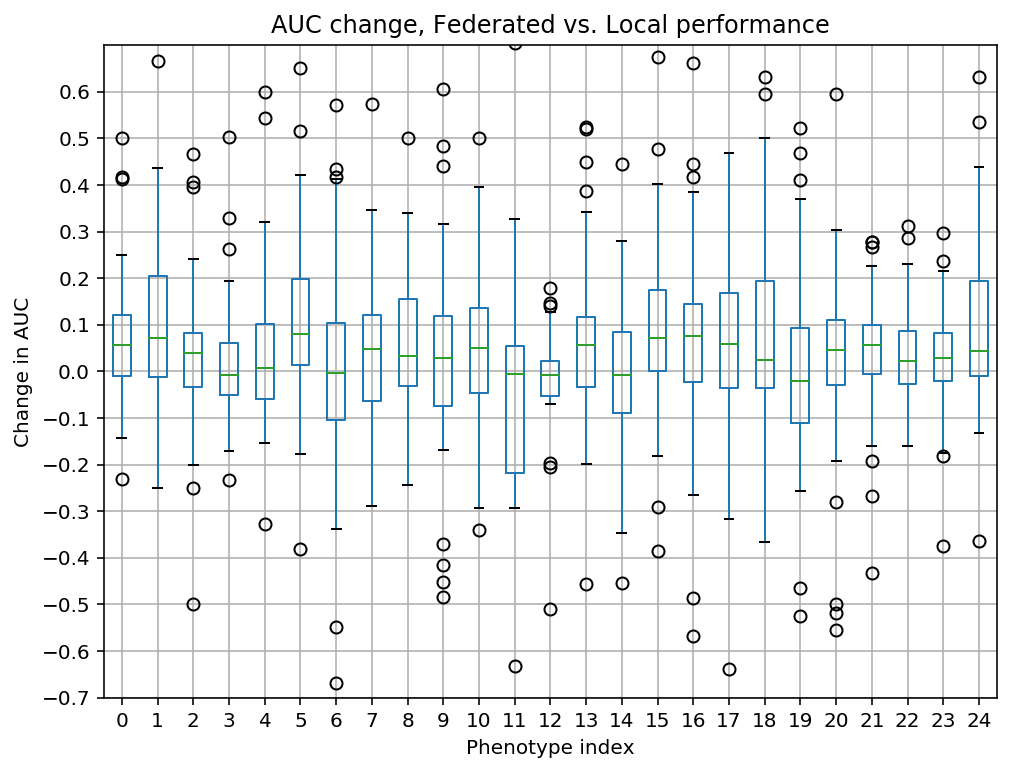

In [494]:
auc_change_pheno.boxplot(figsize=(8,6))
plt.title('AUC change, Federated vs. Local performance')
plt.xlabel('Phenotype index')
plt.ylabel('Change in AUC')
plt.yticks(np.arange(-0.7, 0.7, 0.1))
plt.ylim(-0.7,0.7);

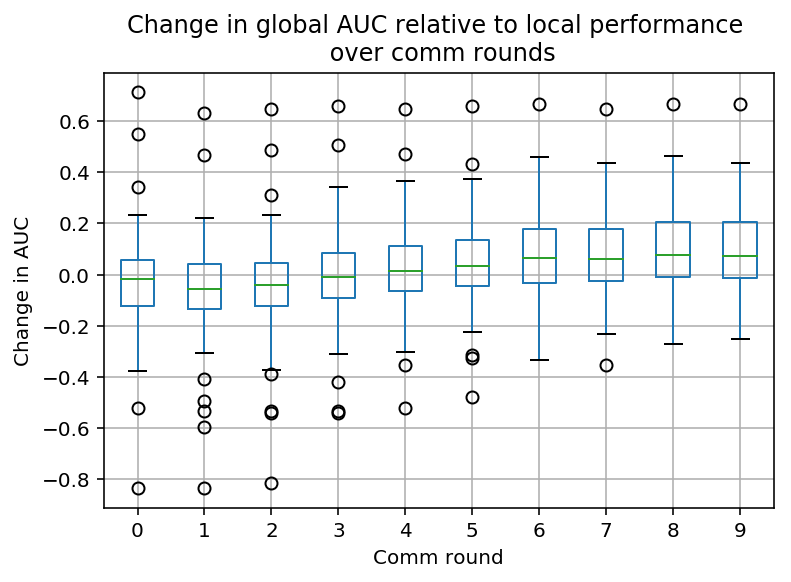

In [567]:
(results_df[0].to_frame()
 .groupby(level=0)
 .apply(lambda df: df.assign(
    val = lambda df: 
     local_perf[0]
     .loc[df.index.get_level_values(0).unique()[0]]))
.pipe(lambda df: df[0] - df['val'])
 .unstack()
 .boxplot())
plt.title('Change in global AUC relative to local performance \n over comm rounds')
plt.xlabel('Comm round')
plt.ylabel('Change in AUC');

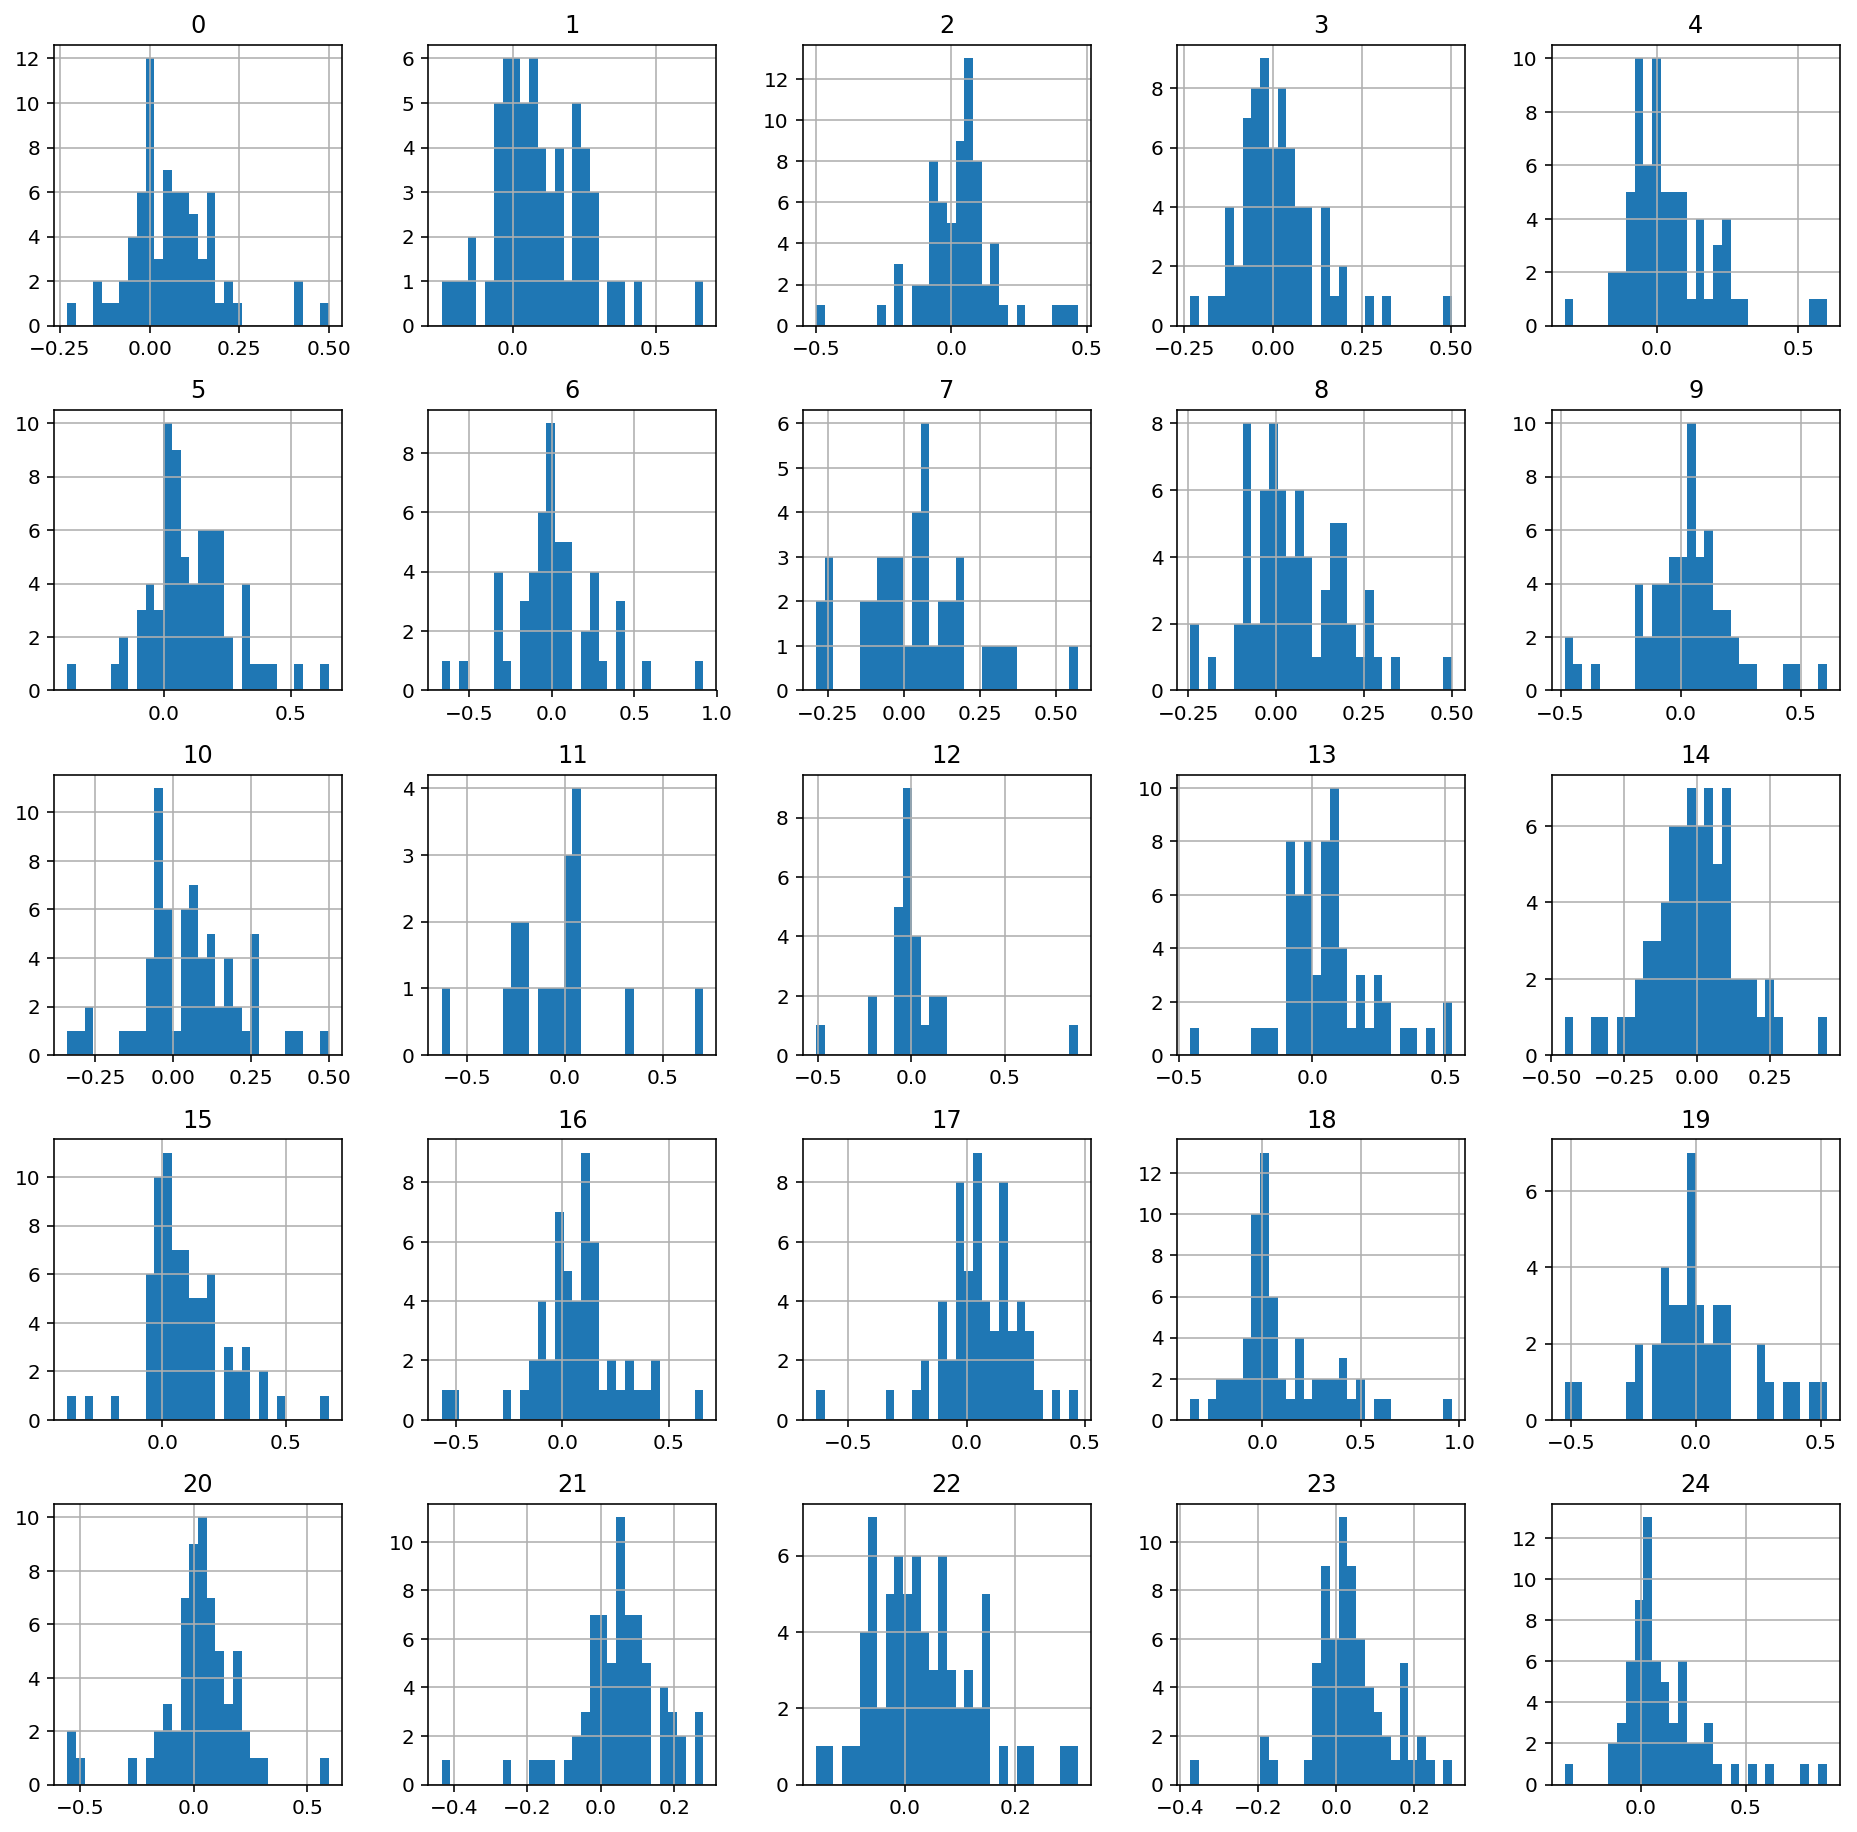

In [313]:
auc_change_pheno.hist(figsize=(16,16), layout=(5,5), bins=30);

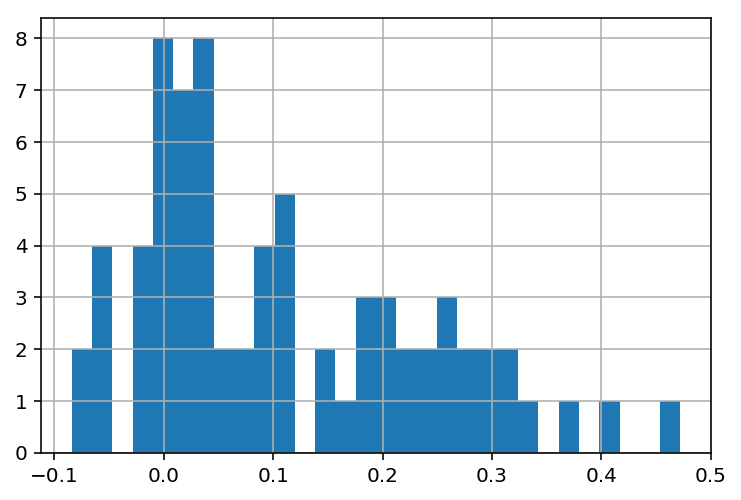

In [147]:
auc_change = (scores_df[9] - local_perf[0])
auc_change.hist(figsize=(6,4), bins=30);

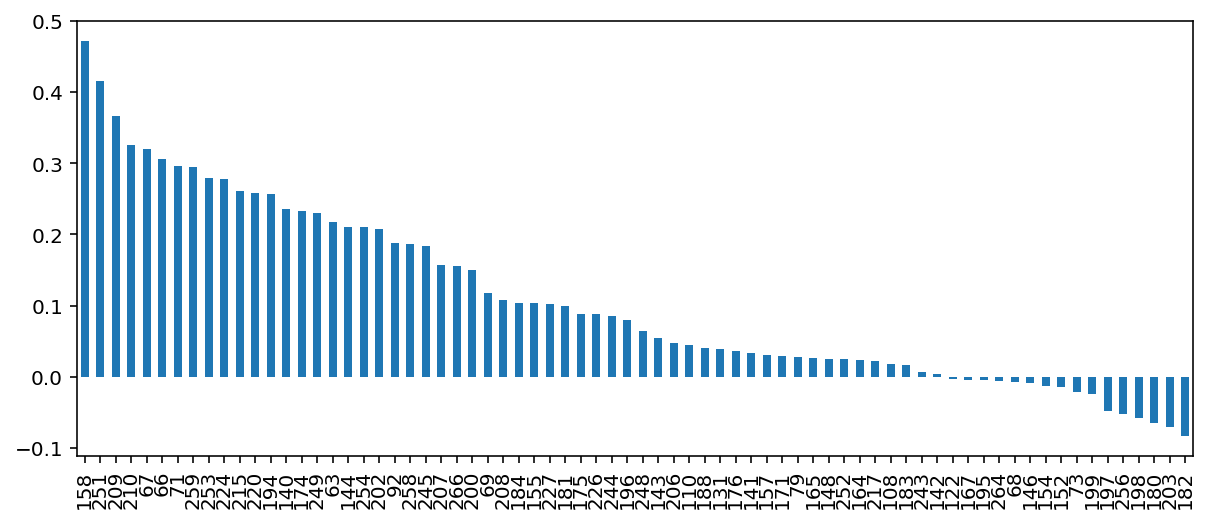

In [321]:
auc_change.sort_values(ascending=False).plot.bar(figsize=(10,4));

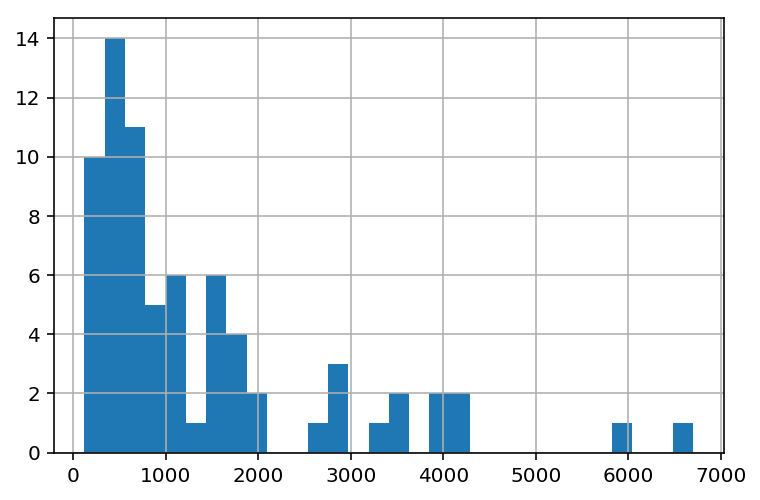

In [153]:
hsp_sizes.hist(bins=30)

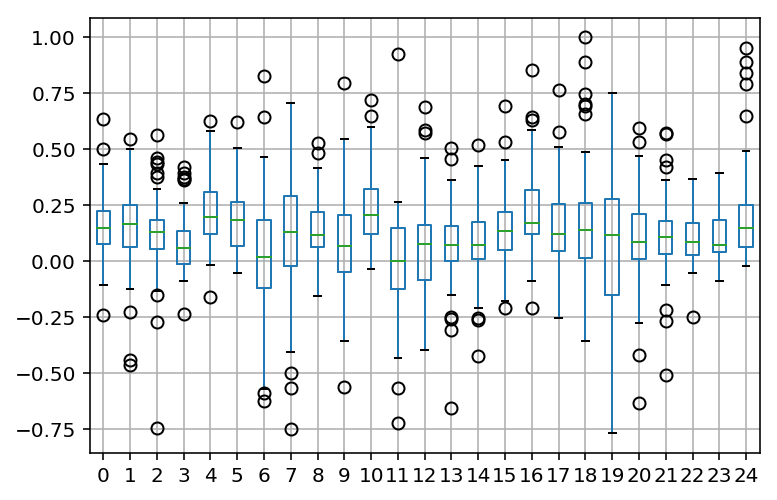

In [571]:
(pooled_df_hsp - local_perf).boxplot()

In [580]:
local_perf.mean().mean()

0.5607844766855459

In [582]:
(pooled_df_hsp - local_perf).mean(axis=0)

0     0.154829
1     0.151225
2     0.117197
3     0.070899
4     0.225138
5     0.185137
6     0.027826
7     0.101030
8     0.147632
9     0.078563
10    0.238691
11   -0.002907
12    0.090832
13    0.068832
14    0.087812
15    0.146787
16    0.226370
17    0.162603
18    0.163228
19    0.056907
20    0.096275
21    0.113492
22    0.097792
23    0.111451
24    0.206240
dtype: float64

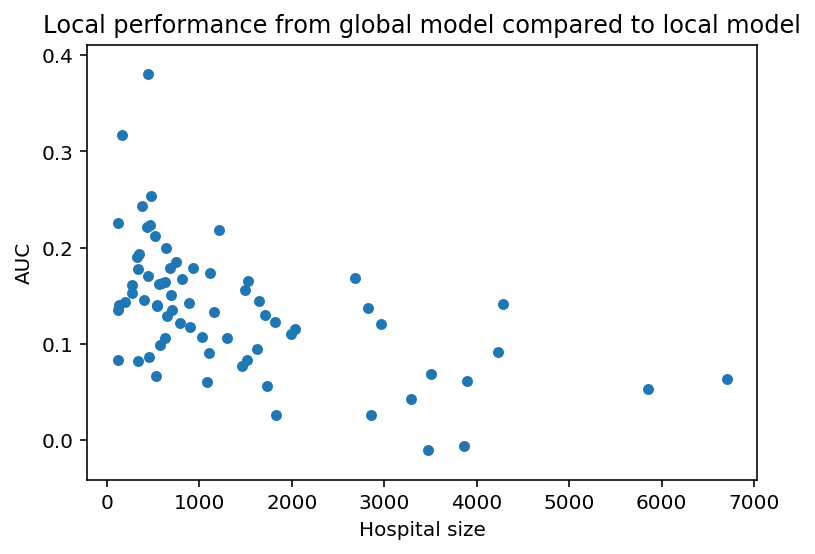

In [578]:
ax = pd.concat([hsp_sizes, (pooled_df_hsp - local_perf).mean(axis=1)], axis=1).plot.scatter(x='hospitalid', y=0)

plt.xlabel('Hospital size')
plt.ylabel('AUC')
plt.title('Local performance from global model compared to local model');

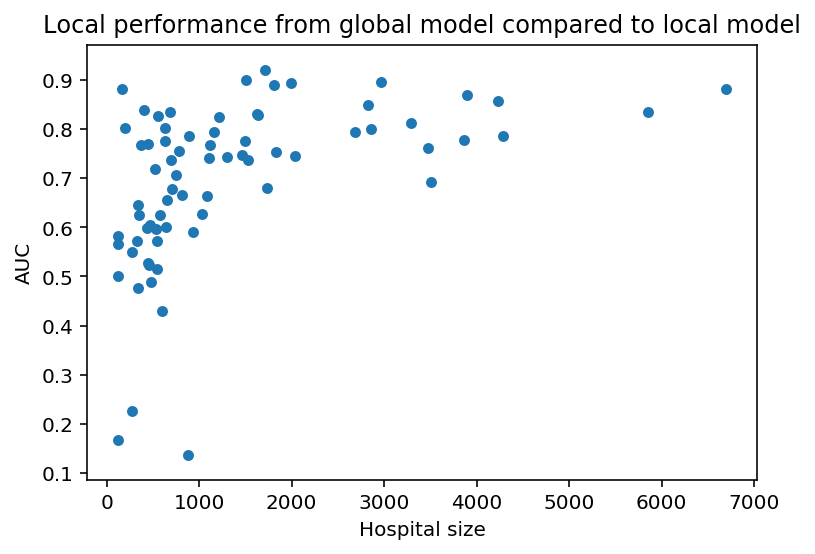

In [157]:
ax = pd.concat([hsp_sizes, local_perf], axis=1).plot.scatter(x='hospitalid', y=0)

plt.xlabel('Hospital size')
plt.ylabel('AUC')
plt.title('Local performance from global model compared to local model');

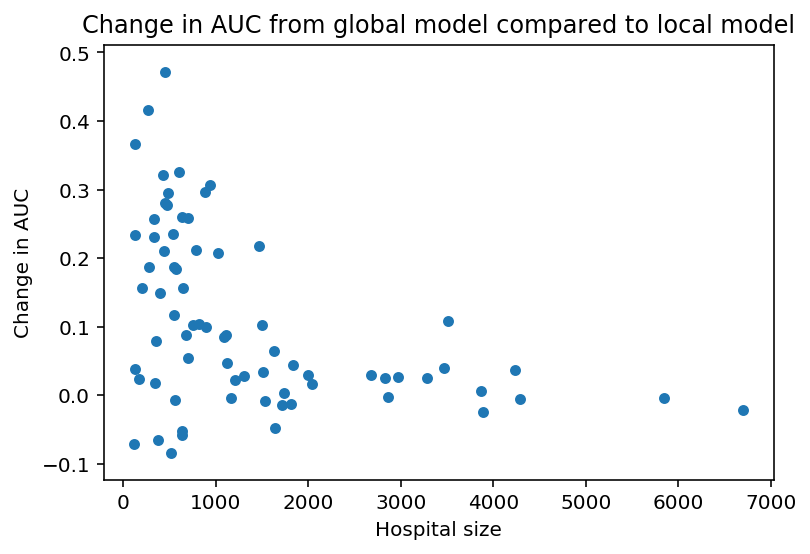

In [150]:
ax = pd.concat([hsp_sizes, auc_change], axis=1).plot.scatter(x='hospitalid', y=0)

plt.xlabel('Hospital size')
plt.ylabel('Change in AUC')
plt.title('Change in AUC from global model compared to local model');

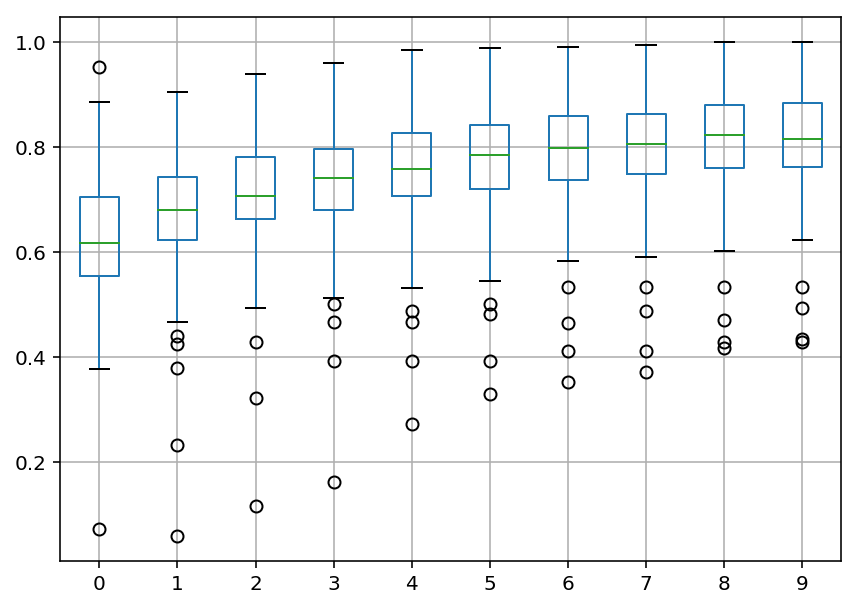

In [146]:
pd.DataFrame.from_dict(results_dict['0']['global_scores']).boxplot(figsize=(7,5));

In [558]:
pooled_df_hsp = pd.DataFrame(np.stack(list(pooled_hsp.values())),
            index=list(pooled_hsp.keys()))

In [184]:
## If correcting json output

timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
output_file = 'experiments/fed-pheno-LSTM_{}.json'.format(timestr)

with open(output_file, 'w') as f:
    json.dump(json.loads(json.dumps(res)), f, indent=4, sort_keys=True)